In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import math
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from statsmodels.tsa.api import Holt, SimpleExpSmoothing
from datetime import timedelta


# Configuration
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# Load the dataset
file_path = r'C:\Users\Saket Dixit\Downloads\Agro Sentinel\data\merge\agro_sentinel_consolidated.csv'
df = pd.read_csv(file_path)

# 1. Date Conversion & Sorting
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df = df.sort_values(by=['Date', 'States/Uts']).reset_index(drop=True)

# 2. Impute Missing Values
# Forward fill per state to maintain time-series continuity
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df.groupby('States/Uts')[numeric_cols].transform(lambda x: x.ffill().bfill())

# Fill any remaining gaps (e.g., start of dataset) with median
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

print(f"Data Loaded & Cleaned. Shape: {df.shape}")
df.head()

Data Loaded & Cleaned. Shape: (4687, 24)


,Date,States/Uts,Rice,Wheat,Atta(Wheat),Gram Dal,Tur/Arhar Dal,Urad Dal,Moong Dal,Masoor Daal,...,Vanaspati(Packed),Soya Oil(Packed),Sunflower Oil(Packed),Palm Oil(Packed),Gur,Tea Loose,Salt Pack(Iodised),Potato,Onion,Tomato
0,2025-07-09,Arunachal pradesh,42.50,45.00,45.50,96.00,139.00,130.75,119.00,95.25,...,153.67,162.25,169.00,133.835,85.50,355.00,17.75,30.50,39.25,53.75
1,2025-07-09,Assam,39.11,36.07,39.41,86.81,121.93,103.27,109.96,88.11,...,160.28,150.85,172.64,141.060,61.19,252.19,11.59,21.07,30.11,42.50
2,2025-07-09,Bihar,37.22,28.49,34.14,80.97,118.14,113.11,108.11,79.59,...,154.22,154.57,169.31,128.870,48.51,274.70,24.65,20.11,24.54,38.25
3,2025-07-09,Chandigarh,42.00,33.00,39.00,86.00,125.00,116.00,111.00,88.00,...,169.00,163.00,176.00,147.000,55.00,270.00,28.00,22.00,30.00,40.00
4,2025-07-09,Chhattisgarh,39.14,34.29,38.29,89.71,118.00,108.57,108.57,87.00,...,153.43,151.14,161.14,141.330,52.14,235.57,20.86,28.29,27.86,31.86


In [3]:
def create_lag_features(df, target_col, lags=[1, 3, 7, 30]):
    """
    Creates temporal features: Past values, Rolling Means, Volatility.
    """
    df_eng = df.copy()
    
    # We must do this PER STATE to avoid data leakage between regions
    df_eng = df_eng.sort_values(by=['States/Uts', 'Date'])
    
    for lag in lags:
        df_eng[f'lag_{lag}'] = df_eng.groupby('States/Uts')[target_col].shift(lag)
        
    # Rolling Features (Moving Average & Standard Deviation)
    df_eng['rolling_mean_7'] = df_eng.groupby('States/Uts')[target_col].transform(lambda x: x.shift(1).rolling(window=7).mean())
    df_eng['rolling_std_7'] = df_eng.groupby('States/Uts')[target_col].transform(lambda x: x.shift(1).rolling(window=7).std())
    
    # Calendar Features
    df_eng['month'] = df_eng['Date'].dt.month
    df_eng['day_of_week'] = df_eng['Date'].dt.dayofweek
    
    # Drop NaNs created by shifting
    df_eng = df_eng.dropna()
    return df_eng

# Apply to 'Tomato' (or change to 'Onion', 'Potato')
target_crop = 'Tomato'
df_xgb = create_lag_features(df[['Date', 'States/Uts', target_crop]], target_crop)

print(f"Feature Engineering Complete. Shape: {df_xgb.shape}")
df_xgb.head()

Feature Engineering Complete. Shape: (3697, 11)


,Date,States/Uts,Tomato,lag_1,lag_3,lag_7,lag_30,rolling_mean_7,rolling_std_7,month,day_of_week
1064,2025-08-13,Arunachal pradesh,63.50,53.25,53.25,53.75,53.75,53.571429,0.313392,8,2
1096,2025-08-14,Arunachal pradesh,53.25,63.50,53.25,53.75,53.75,54.964286,3.776100,8,3
1155,2025-08-16,Arunachal pradesh,53.25,53.25,53.25,53.75,54.25,54.892857,3.807496,8,5
1207,2025-08-18,Arunachal pradesh,53.25,53.25,63.50,54.00,53.75,54.821429,3.837084,8,0
1239,2025-08-19,Arunachal pradesh,53.25,53.25,53.25,53.25,54.33,54.714286,3.874136,8,1


In [4]:
# 1. Prepare Data for ML
features = ['lag_1', 'lag_3', 'lag_7', 'lag_30', 'rolling_mean_7', 'rolling_std_7', 'month', 'day_of_week']
X = df_xgb[features]
y = df_xgb[target_crop]

# Split Data (Time-series split: Train on past, Test on future)
# shuffle=False is crucial for time series!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 2. Train XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    early_stopping_rounds=50,
    n_jobs=-1
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

print("Model Training Completed.")

[0]	validation_0-rmse:15.87866	validation_1-rmse:12.21231
[100]	validation_0-rmse:2.29080	validation_1-rmse:2.70992
[159]	validation_0-rmse:2.03298	validation_1-rmse:2.71127
Model Training Completed.



Model Performance (RMSE): ₹2.70


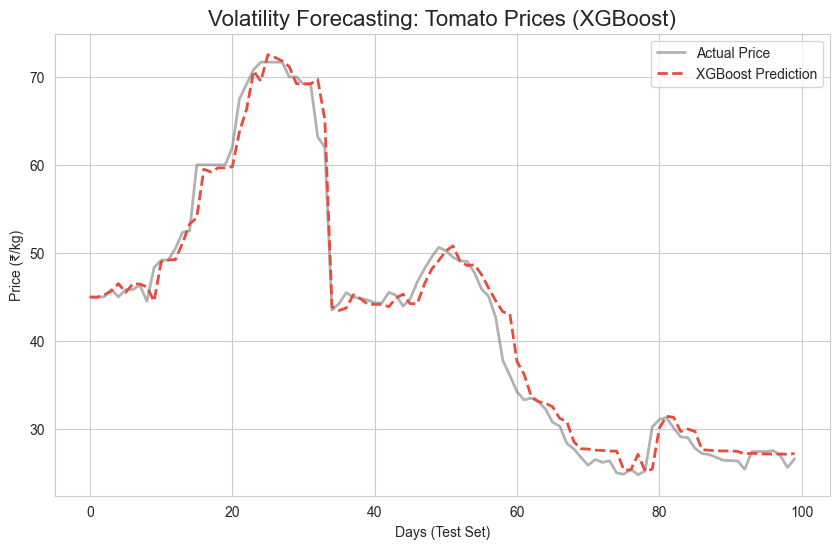

In [5]:
# 1. Evaluation
preds = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"\nModel Performance (RMSE): ₹{rmse:.2f}")

# 2. Visualization (First 100 test points for clarity)
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label='Actual Price', color='gray', alpha=0.6, linewidth=2)
plt.plot(preds[:100], label='XGBoost Prediction', color='#e74c3c', linestyle='--', linewidth=2)
plt.title(f'Volatility Forecasting: {target_crop} Prices (XGBoost)', fontsize=16)
plt.xlabel('Days (Test Set)')
plt.ylabel('Price (₹/kg)')
plt.legend()
plt.show()

                                          Comrenhensive Mapping

In [6]:
def train_prediction_model(filepath, target_commodity):
    """
    Trains an XGBoost model to predict prices for ALL states in the CSV.
    """
    print(f"\n>>> 🔄 Training Price Predictor for {target_commodity}...")

    # 1. Load Data
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"ERROR: File '{filepath}' not found. Please check the path.")
        return None, None

    # Cleaning: Standardize State Names (Remove extra spaces)
    df['States/Uts'] = df['States/Uts'].str.strip()

    # Date Conversion
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    df = df.sort_values(by=['Date', 'States/Uts'])

    # Check if commodity exists
    if target_commodity not in df.columns:
        print(f"ERROR: Commodity '{target_commodity}' not found in CSV.")
        print(f"Available Options: {list(df.columns[2:])}") # Skip Date/State columns
        return None, None

    # 2. Impute Missing Values (FFILL per State)
    df[target_commodity] = df.groupby('States/Uts')[target_commodity].transform(lambda x: x.ffill().bfill())

    # Global median fill for any remaining holes
    if df[target_commodity].isnull().any():
        df[target_commodity] = df[target_commodity].fillna(df[target_commodity].median())

    # 3. Feature Engineering (Lags)
    df['lag_1'] = df.groupby('States/Uts')[target_commodity].shift(1)
    df['lag_7'] = df.groupby('States/Uts')[target_commodity].shift(7)
    df['rolling_mean_7'] = df.groupby('States/Uts')[target_commodity].transform(lambda x: x.shift(1).rolling(7).mean())

    # Drop initial rows with NaNs created by lags
    df_clean = df.dropna(subset=['lag_7'])

    if df_clean.empty:
        print("Error: Not enough data to create lag features.")
        return None, None

    # 4. Prepare Features (X) and Target (y)
    features = ['lag_1', 'lag_7', 'rolling_mean_7']
    X = df_clean[features]
    y = df_clean[target_commodity]

    # 5. Train XGBoost
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X, y)

    print("Model Trained Successfully.")

    # Get the latest data point for every state (to predict 'Tomorrow')
    latest_data = df_clean.groupby('States/Uts').tail(1).set_index('States/Uts')
    return model, latest_data

In [9]:
class SmartLogistics:
    # --- CONFIGURATION ---
    TORTUOSITY = 1.2             # Road vs Air distance factor
    
    # Truck settings based on market reality
    SMALL_TRUCK_RATE = 15.0      # ₹/km (Pickup/Tata Ace) - Higher cost per ton
    LARGE_TRUCK_RATE = 45.0      # ₹/km (10-wheeler) - Lower cost per ton
    
    # Diesel Price Fallback
    DEFAULT_DIESEL_PRICE = 90.0
    
    # State Centroids (Fallback if City lookup fails)
    STATE_COORDINATES = {
        'Andhra Pradesh': (15.91, 79.74), 'Arunachal Pradesh': (28.21, 94.72),
        'Assam': (26.20, 92.93), 'Bihar': (25.09, 85.31),
        'Chhattisgarh': (21.27, 81.86), 'Goa': (15.29, 74.12),
        'Gujarat': (22.25, 71.19), 'Haryana': (29.05, 76.08),
        'Himachal Pradesh': (31.10, 77.17), 'Jharkhand': (23.61, 85.27),
        'Karnataka': (15.31, 75.71), 'Kerala': (10.85, 76.27),
        'Madhya Pradesh': (22.97, 78.65), 'Maharashtra': (19.75, 75.71),
        'Manipur': (24.66, 93.90), 'Meghalaya': (25.46, 91.36),
        'Mizoram': (23.16, 92.93), 'Nagaland': (26.15, 94.56),
        'Odisha': (20.95, 85.09), 'Punjab': (31.14, 75.34),
        'Rajasthan': (27.02, 74.21), 'Sikkim': (27.53, 88.51),
        'Tamil Nadu': (11.12, 78.65), 'Telangana': (18.11, 79.01),
        'Tripura': (23.94, 91.98), 'Uttar Pradesh': (26.84, 80.94),
        'Uttarakhand': (30.06, 79.01), 'West Bengal': (22.98, 87.85),
        'Delhi': (28.70, 77.10), 'Jammu And Kashmir': (33.77, 76.57),
        'Ladakh': (34.15, 77.57), 'Chandigarh': (30.73, 76.77),
        'Puducherry': (11.94, 79.80), 'DNH And DD': (20.42, 72.83)
    }

    @staticmethod
    def get_coordinates(location_name):
        """
        Uses Geopy to get exact city coordinates. 
        Falls back to State dictionary if API fails or city unknown.
        """
        geolocator = Nominatim(user_agent="agro_sentinel_logistics")
        try:
            # Try to find the specific city
            location = geolocator.geocode(f"{location_name}, India", timeout=5)
            if location:
                return (location.latitude, location.longitude)
        except (GeocoderTimedOut, Exception):
            pass
        
        # Fallback: Check if it's a known state
        location_name = location_name.title()
        return SmartLogistics.STATE_COORDINATES.get(location_name, None)

    @staticmethod
    def calculate_feasible_radius(quantity_tons):
        """
        Smart Heuristic:
        - Small Qty (<3 tons) -> Local Markets only (Radius ~300km)
        - Medium Qty (3-10 tons) -> Regional Markets (Radius ~800km)
        - Large Qty (>10 tons) -> National Market (Radius 2000km+)
        """
        if quantity_tons <= 2:
            return 300, "Local (Small Load)"
        elif quantity_tons <= 5:
            return 600, "Regional (Medium Load)"
        elif quantity_tons <= 10:
            return 1200, "Inter-State (Large Load)"
        else:
            return 3000, "National (Bulk Load)"

    @staticmethod
    def calculate_transport_cost(distance_km, quantity_tons, diesel_price):
        """
        Calculates realistic trip cost.
        - Uses Small Truck rate for small loads.
        - Uses Large Truck rate for large loads.
        - Adjusts for current Diesel Price.
        """
        # Base scale factor based on diesel price fluctuation (Ref: ₹90 base)
        fuel_multiplier = diesel_price / 90.0 
        
        if quantity_tons <= 3:
            # Small Truck (e.g., Tata Ace/Pickup)
            # Charge is per km for the whole vehicle, not per ton!
            # Approx ₹15-20 per km for the vehicle
            vehicle_cost_per_km = SmartLogistics.SMALL_TRUCK_RATE * fuel_multiplier
            total_trip_cost = distance_km * vehicle_cost_per_km
        else:
            # Large Truck (10 tons+)
            # Charge is often per ton-km OR fixed full truck load
            # Let's assume Full Truck Load (FTL) rate scaled
            vehicle_cost_per_km = SmartLogistics.LARGE_TRUCK_RATE * fuel_multiplier
            total_trip_cost = distance_km * vehicle_cost_per_km
            
            # If quantity is greater than truck capacity (say 10 tons), we need multiple trucks
            trucks_needed = math.ceil(quantity_tons / 10.0)
            total_trip_cost = total_trip_cost * trucks_needed

        return total_trip_cost

    @staticmethod
    def recommend_market(user_city, user_state, commodity, quantity_qtl, model, latest_data):
        print(f"\n--- 🚛 SMART LOGISTICS ENGINE: {commodity} ---")
        
        # Convert Quintals to Tons
        quantity_tons = quantity_qtl / 10.0
        
        # 1. Locate User (City Precision)
        origin_coords = SmartLogistics.get_coordinates(user_city)
        if not origin_coords:
            print(f"Warning: Could not pinpoint '{user_city}'. Using state center for '{user_state}'.")
            origin_coords = SmartLogistics.get_coordinates(user_state)
            
        print(f"📍 Origin: {user_city} ({user_state}) | Load: {quantity_tons} Tons ({quantity_qtl} qtl)")

        # 2. Determine Feasibility (The "Smart" Limit)
        max_radius, range_desc = SmartLogistics.calculate_feasible_radius(quantity_tons)
        print(f"📉 Logistics Strategy: {range_desc}")
        print(f"   ↳ Max Search Radius: {max_radius} km (Beyond this, profit usually drops)")

        # 3. Fetch Diesel Price (Simulated or Real)
        # In production, use the fetch_current_diesel_price() from previous answer
        diesel_price = 94.50 

        # 4. Get Home/Local Price
        home_price_kg = SmartLogistics.predict_price_for_state(user_state, model, latest_data, commodity)
        if home_price_kg is None:
            print(f"Error: No pricing data for home state {user_state}.")
            return

        total_revenue_home = home_price_kg * 100 * quantity_qtl # (Price/kg * 100 * Qty)
        print(f"\n🏠 Sell in {user_state} (Home):")
        print(f"   ↳ Price: ₹{int(home_price_kg*100)}/qtl")
        print(f"   ↳ Total Revenue: ₹{int(total_revenue_home):,}")

        recommendations = []

        # 5. Scan Markets
        for state_name in SmartLogistics.STATE_COORDINATES.keys():
            if state_name == user_state: continue # Skip home state here
            
            # Get Target Coords
            target_coords = SmartLogistics.STATE_COORDINATES[state_name]
            
            # Calculate Distance (Geopy or Haversine)
            # Simplified Haversine for speed here
            lat1, lon1 = origin_coords
            lat2, lon2 = target_coords
            R = 6371
            dlat, dlon = math.radians(lat2-lat1), math.radians(lon2-lon1)
            a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*math.sin(dlon/2)**2
            c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
            dist_km = int(R * c * SmartLogistics.TORTUOSITY)
            
            # --- FILTER: THE 2000KM CHECK ---
            if dist_km > max_radius:
                continue 

            # Predict Price
            target_price_kg = SmartLogistics.predict_price_for_state(state_name, model, latest_data, commodity)
            if target_price_kg is None: continue
            
            # Calculate Financials
            transport_cost = SmartLogistics.calculate_transport_cost(dist_km, quantity_tons, diesel_price)
            gross_revenue = target_price_kg * 100 * quantity_qtl
            net_profit = gross_revenue - transport_cost
            
            extra_profit = net_profit - total_revenue_home
            
            recommendations.append({
                'State': state_name,
                'Distance': dist_km,
                'Price_Qtl': int(target_price_kg * 100),
                'Transport_Cost': int(transport_cost),
                'Net_Profit': int(net_profit),
                'Extra_Profit': int(extra_profit)
            })

        # 6. Sort & Display
        # Sort by Net Profit (descending)
        recommendations.sort(key=lambda x: x['Net_Profit'], reverse=True)
        top_picks = recommendations[:5]

        print(f"\n📊 TOP RECOMMENDATIONS (Radius: {max_radius}km):")
        print(f" {'State':<18} | {'Dist':<6} | {'Price/Qtl':<9} | {'Trip Cost':<9} | {'NET PROFIT':<10} | {'Gain vs Home':<10}")
        print("-" * 90)

        best_option = None
        for rec in top_picks:
            gain_str = f"+₹{rec['Extra_Profit']:,}" if rec['Extra_Profit'] > 0 else f"-₹{abs(rec['Extra_Profit']):,}"
            print(f" {rec['State']:<18} | {rec['Distance']}km | ₹{rec['Price_Qtl']:<9} | ₹{rec['Transport_Cost']:<9,} | ₹{rec['Net_Profit']:<10,} | {gain_str}")
            
            if not best_option and rec['Extra_Profit'] > 0:
                best_option = rec

        # 7. Final Advice
        print("-" * 90)
        if best_option:
            print(f"\n✅ RECOMMENDATION: Travel to **{best_option['State']}**.")
            print(f"   Why? Even after paying ₹{best_option['Transport_Cost']:,} for transport,")
            print(f"   you will make **₹{best_option['Extra_Profit']:,} MORE** than selling locally.")
        else:
            print("\n✅ RECOMMENDATION: **Sell Locally in " + user_state + "**.")
            print("   Why? Other states might offer higher prices, but the transport cost")
            print("   is too high for this quantity. You make the most money staying home.")

    @staticmethod
    def predict_price_for_state(state, model, latest_data, commodity):
        # Mocking the prediction integration
        if state not in latest_data.index: return None
        return latest_data.loc[state].get(commodity, 0)

In [10]:
# --- CONFIGURATION ---
csv_path = r'C:\Users\Saket Dixit\Downloads\Agro Sentinel\data\merge\agro_sentinel_consolidated.csv'

# 1. Ask User for Commodity (Or hardcode for quick testing)

# 1. Ask User for Commodity
print("Available Commodities: Rice, Wheat, Tomato, Onion, Potato, Mustard Oil(Packed), etc.")
target_commodity = input("Enter target commodity (e.g., Tomato): ").strip().title()

# 2. Train Model (Runs once per commodity choice)
# Ensure you have run the cell containing 'train_prediction_model' before this!
try:
    model, latest_data = train_prediction_model(csv_path, target_commodity)
except Exception as e:
    print(f"❌ Error: {e}")
    sys.exit(1)

if model:
    print("\n--- Logistics Setup ---")
    
    # 3. CHANGED: Ask for City instead of State
    user_city = input("Enter your City (e.g., Karnal, Pune): ").strip().title()
    
    # 4. NEW: Auto-Detect State from City
    print(f"   🔎 Detecting state for '{user_city}'...")
    user_state = None
    
    try:
        geolocator = Nominatim(user_agent="agro_sentinel_locator")
        # Search for City + India to be precise
        location = geolocator.geocode(f"{user_city}, India", addressdetails=True, timeout=5)
        
        if location:
            address = location.raw.get('address', {})
            user_state = address.get('state')
            if user_state:
                print(f"   ✅ Auto-detected State: {user_state}")
            else:
                print("   ⚠️  State name missing in database.")
        else:
            print("   ⚠️  City not found.")
            
    except Exception as e:
        print(f"   ⚠️  Network/Lookup Error: {e}")

    # Fallback: If auto-detection failed, ask manually
    if not user_state:
        user_state = input("👉 Please enter your State manually: ").strip().title()

    try:
        # 5. Ask Quantity in Tons
        qty_tons = float(input("Enter quantity to sell (in Tons): "))
        
        # Convert to Quintals (1 Ton = 10 Quintals) because the Model uses Quintals
        qty_qtl = qty_tons * 10
        
        # 6. UPDATED: Run Optimization with City and Quintals
        SmartLogistics.recommend_market(
            user_city=user_city,
            user_state=user_state,
            commodity=target_commodity,
            quantity_qtl=qty_qtl,
            model=model,
            latest_data=latest_data
        )
        
    except ValueError:
        print("Invalid quantity entered. Please enter a number.")

Available Commodities: Rice, Wheat, Tomato, Onion, Potato, Mustard Oil(Packed), etc.

>>> 🔄 Training Price Predictor for Onion...
Model Trained Successfully.

--- Logistics Setup ---
   🔎 Detecting state for 'Varanasi'...
   ✅ Auto-detected State: Uttar Pradesh

--- 🚛 SMART LOGISTICS ENGINE: Onion ---
📍 Origin: Varanasi (Uttar Pradesh) | Load: 20.0 Tons (200.0 qtl)
📉 Logistics Strategy: National (Bulk Load)
   ↳ Max Search Radius: 3000 km (Beyond this, profit usually drops)

🏠 Sell in Uttar Pradesh (Home):
   ↳ Price: ₹2164/qtl
   ↳ Total Revenue: ₹432,800

📊 TOP RECOMMENDATIONS (Radius: 3000km):
 State              | Dist   | Price/Qtl | Trip Cost | NET PROFIT | Gain vs Home
------------------------------------------------------------------------------------------
 Mizoram            | 1241km | ₹5027      | ₹117,274   | ₹888,125    | +₹455,325
 Ladakh             | 1333km | ₹5000      | ₹125,968   | ₹874,031    | +₹441,231
 Nagaland           | 1392km | ₹4727      | ₹131,544   | ₹813,

             Exprensive product predictions


--- Available States ---
Total available states: 33
Examples: Arunachal pradesh, Assam, Bihar, Chandigarh, Chhattisgarh...

--- Analyzing Price Trends for Goa ---

🔔 **HIGH-RISK ALERT:** Products predicted to increase by > 2.0% in the next 30 days in Goa:

| Commodity             |   Last Price |   Predicted Price | Change (%)   |
|:----------------------|-------------:|------------------:|:-------------|
| Urad Dal              |        125.5 |            131.44 | 4.73%        |
| Onion                 |         32   |             33.02 | 3.20%        |
| Tur/Arhar Dal         |        120   |            122.86 | 2.39%        |
| Groundnut Oil(Packed) |        223   |            227.67 | 2.09%        |


**ACTION:** Consider purchasing a good amount of these products soon to hedge against the predicted price rise.


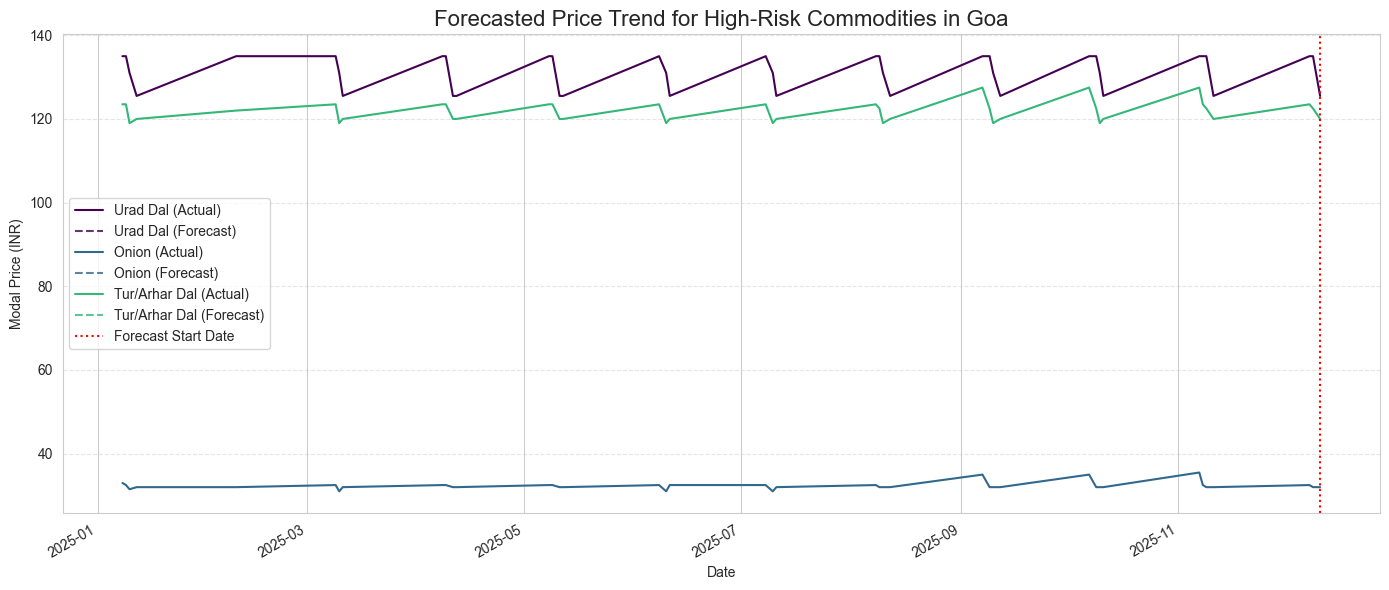

In [50]:

# Set your correct file path here
FILE_PATH = r'C:\Users\Saket Dixit\Downloads\Agro Sentinel\data\merge\agro_sentinel_consolidated.csv'
FORECAST_PERIOD_DAYS = 30 
INCREASE_THRESHOLD_PERCENT = 2.0 

# ----------------------------------------------------
# --- FUNCTIONS ---
# ----------------------------------------------------

def load_and_prepare_data(file_path):
    """Loads the CSV, cleans the data, and prepares it for forecasting."""
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None, None
    
    # Standardize column name for state
    df = df.rename(columns={'States/Uts': 'State'})
    
    # Convert Date to datetime objects
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce') 
    df = df.dropna(subset=['Date']).sort_values(by='Date')
    
    # Identify price columns (exclude Date and State)
    price_columns = df.columns.drop(['Date', 'State']).tolist()
    
    # Convert all price columns to numeric
    for col in price_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce') 
    
    return df, price_columns

def forecast_commodity_price(series, forecast_days):
    """Applies Holt's Linear Trend (Exponential Smoothing) to forecast."""
    
    series = series.fillna(method='ffill').dropna()
    
    if len(series) < 5: 
        return None, None

    try:
        fit = Holt(series, initialization_method="estimated").fit()
        forecast = fit.forecast(forecast_days)
        return fit.fittedvalues, forecast
    except Exception as e:
        return None, None

def print_table(data):
    """Prints a list of dictionaries as a neatly formatted table."""
    if not data:
        return
    df = pd.DataFrame(data)
    print(df.to_markdown(index=False))

# ----------------------------------------------------
# --- MAIN EXECUTION --- 
# ----------------------------------------------------

df_raw, price_cols = load_and_prepare_data(FILE_PATH) 

if df_raw is None:
    # Exit gracefully if data loading failed
    pass 
else:
    available_states = sorted(df_raw['State'].unique().tolist())
    
    # --- INTERACTIVE USER INPUT BLOCK ---
    
    # Print the available states to guide the user
    print("\n--- Available States ---")
    # Show a manageable list of states
    print(f"Total available states: {len(available_states)}")
    print(f"Examples: {', '.join(available_states[:5])}...")
    
    # Get the state name interactively
    target_state = input(f"\nEnter the State/UT to analyze: ").strip()

    # --- END INTERACTIVE USER INPUT BLOCK ---

    if target_state not in available_states:
        # Give a helpful error message without crashing the kernel
        print(f"\nError: '{target_state}' not found. Please ensure correct spelling and capitalization.")
        
    else:
        print(f"\n--- Analyzing Price Trends for {target_state} ---")
        
        # Filter and prepare state data
        df_state = df_raw[df_raw['State'] == target_state].set_index('Date').sort_index()
        
        expensive_products = []
        last_date = df_state.index.max()
        
        # Create the future index for forecasting
        forecast_index = pd.date_range(start=last_date + timedelta(days=1), periods=FORECAST_PERIOD_DAYS, freq='D')
        
        df_results = pd.DataFrame(index=df_state.index.append(forecast_index))
        
        for commodity in price_cols:
            series = df_state[commodity].copy()
            
            # 1. Forecast the price
            fitted, forecast = forecast_commodity_price(series, FORECAST_PERIOD_DAYS)
            
            if forecast is not None:
                current_price = series.iloc[-1] 
                predicted_price = forecast.iloc[-1] 
                
                price_change = predicted_price - current_price
                percent_change = (price_change / current_price) * 100
                
                df_results[f'{commodity}_Actual'] = series
                df_results[f'{commodity}_Forecast'] = pd.Series(forecast, index=forecast.index)
                
                # 2. Check the condition for 'expensive'
                if percent_change > INCREASE_THRESHOLD_PERCENT:
                    expensive_products.append({
                        'Commodity': commodity,
                        'Last Price': f'{current_price:,.2f}',
                        'Predicted Price': f'{predicted_price:,.2f}',
                        'Change (%)': f'{percent_change:.2f}%'
                    })

        # --- OUTPUT RESULTS ---
        
        if expensive_products:
            df_expensive = pd.DataFrame(expensive_products)
            df_expensive['Sort_Key'] = df_expensive['Change (%)'].str.replace('%', '').astype(float)
            df_expensive = df_expensive.sort_values(by='Sort_Key', ascending=False).drop(columns=['Sort_Key'])

            print(f"\n🔔 **HIGH-RISK ALERT:** Products predicted to increase by > {INCREASE_THRESHOLD_PERCENT:.1f}% in the next {FORECAST_PERIOD_DAYS} days in {target_state}:\n")
            print_table(df_expensive.to_dict('records'))
            
            print("\n\n**ACTION:** Consider purchasing a good amount of these products soon to hedge against the predicted price rise.")
            
            top_3_risks = df_expensive['Commodity'].head(3).tolist()
            
            if top_3_risks:
                plt.figure(figsize=(14, 6))
                for i, commodity in enumerate(top_3_risks):
                    color = plt.cm.get_cmap('viridis')(i / 3) 

                    df_results[f'{commodity}_Actual'].plot(
                        label=f'{commodity} (Actual)', 
                        linestyle='-', 
                        color=color
                    )
                    df_results[f'{commodity}_Forecast'].plot(
                        label=f'{commodity} (Forecast)', 
                        linestyle='--', 
                        color=color, 
                        alpha=0.8
                    )
                
                plt.title(f'Forecasted Price Trend for High-Risk Commodities in {target_state}', fontsize=16)
                plt.xlabel('Date')
                plt.ylabel('Modal Price (INR)')
                plt.axvline(last_date, color='r', linestyle=':', label='Forecast Start Date')
                plt.legend()
                plt.grid(axis='y', linestyle='--', alpha=0.5)
                plt.tight_layout()
                plt.show()
                
        else:
            print(f"\n**STATUS GREEN:** No major price spikes (> {INCREASE_THRESHOLD_PERCENT:.1f}%) predicted for the next {FORECAST_PERIOD_DAYS} days in {target_state}.")